# Task one

I have chosen the data from 2017 from Vanautu.
The data and metadata were downloaded from [here](http://www.bom.gov.au/oceanography/projects/spslcmp/data/index.shtml).

## Source of data

Describe the source of the data.

## Display and describe data

First load in the data and see what it is from description and plots.

In [103]:
using Pkg
Pkg.activate("..")

  Activating environment at `~/Documents/GitHub/MATH5271/Project.toml`


In [104]:
using CSV, DataFrames, Plots, Dates

Ignore the warnings below. 
They are just saying that columns without entries (that is the `Vanuatu` column) is being populated with `missing`.

In [105]:
vanuatu_2017 = CSV.File("IDO70009_2017.csv")
df_van = DataFrame(vanuatu_2017)
ENV["COLUMNS"] = 160 # This just allows the display of all the columns
first(df_van, 10)

┌ Warning: thread = 1 warning: only found 10 / 11 columns around data row: 1. Filling remaining columns with `missing`
└ @ CSV /Users/Joey/.julia/packages/CSV/bLdMU/src/file.jl:621
┌ Warning: thread = 1 warning: only found 10 / 11 columns around data row: 2. Filling remaining columns with `missing`
└ @ CSV /Users/Joey/.julia/packages/CSV/bLdMU/src/file.jl:621
┌ Warning: thread = 1 warning: only found 10 / 11 columns around data row: 3. Filling remaining columns with `missing`
└ @ CSV /Users/Joey/.julia/packages/CSV/bLdMU/src/file.jl:621
┌ Warning: thread = 1 warning: only found 10 / 11 columns around data row: 4. Filling remaining columns with `missing`
└ @ CSV /Users/Joey/.julia/packages/CSV/bLdMU/src/file.jl:621
┌ Warning: thread = 1 warning: only found 10 / 11 columns around data row: 5. Filling remaining columns with `missing`
└ @ CSV /Users/Joey/.julia/packages/CSV/bLdMU/src/file.jl:621
┌ Warning: thread = 1 warning: only found 10 / 11 columns around data row: 6. Filling remaining

,Date & UTC Time,Sea Level,Water Temperature,Air Temperature,Barometric Pressure,Residuals,Adjusted Residuals,Wind Direction,Wind Gust,Wind Speed,Vanuatu
,String31,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Missing
1,01-Jan-2017 00:00,1.007,28.0,27.5,1006.5,0.019,-0.043,335,4.9,1.8,missing
2,01-Jan-2017 01:00,0.88,28.0,28.0,1006.0,0.029,-0.038,302,6.3,1.9,missing
3,01-Jan-2017 02:00,0.799,28.0,28.2,1005.7,0.035,-0.038,296,6.5,2.0,missing
4,01-Jan-2017 03:00,0.787,28.1,27.0,1005.3,0.031,-0.044,296,5.2,1.0,missing
5,01-Jan-2017 04:00,0.864,28.1,26.9,1005.0,0.028,-0.051,72,4.0,1.4,missing
6,01-Jan-2017 05:00,1.004,27.9,27.4,1005.0,0.021,-0.061,67,5.8,3.3,missing
7,01-Jan-2017 06:00,1.169,27.9,26.9,1005.4,0.018,-0.064,79,5.0,1.5,missing
8,01-Jan-2017 07:00,1.299,27.9,24.2,1006.2,0.004,-0.073,74,4.2,1.1,missing
9,01-Jan-2017 08:00,1.366,27.9,24.5,1006.4,-0.009,-0.078,188,3.1,0.7,missing


In [106]:
describe(df_van)


,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,Date & UTC Time,,01-Apr-2017 00:00,,31-Oct-2017 23:00,0,String31
2,Sea Level,-32.2527,-9999.0,0.86,1.611,0,Float64
3,Water Temperature,-139.772,-9999.0,27.0,31.0,0,Float64
4,Air Temperature,-7.48828,-9999.0,25.6,32.7,0,Float64
5,Barometric Pressure,974.919,-9999.0,1011.2,1020.0,0,Float64
6,Residuals,-33.1366,-9999.0,-0.031,0.11,0,Float64
7,Adjusted Residuals,-33.1552,-9999.0,-0.054,0.128,0,Float64
8,Wind Direction,118.115,-9999,165.0,360,0,Int64
9,Wind Gust,-26.1054,-9999.0,2.9,19.3,0,Float64


The data contains hourly observations recorded between midnight 1st January 2017 and 23:00 31st December 2017 of:
* sea Level
* water temperature 
* air temperature
* barometric pressure
* wind direction
* wind gust
* wind speed.

In total there are 8760 observations.
From the summaray of the data above there are minimum entries in all measureable columns of -9999. 
These are unrealistic so must be what happens for missing data or when an error is entered incorrectly.

For convenience the variables are renamed to something without white space and a little shorter.

In [107]:
rename!(df_van, ["datetime", "sea_level", "water_temp", "air_temp", 
        "barometric_press", "residuals", "adj_residuals", "wind_dir",
        "wind_gust", "wind_speed", "Vanuatu"]);

The `datetime` variable is a string however julia has a package to deal with dates which we are going to use however, to take advantage of the `Dates.jl` package, we need to create a new column that has date and time in the correct format.

In [108]:
new_date = DateTime(2017, 1, 1, 00, 00, 00):Dates.Hour(1):DateTime(2017, 12, 31, 23, 00, 00)
insertcols!(df_van, 2, :datetime2 => new_date);


## Extract and clean data for `Sea level`, `Water Temperature`, and `Air Temperature`.
We are interested in the `Sea level`, `Water Temperature`, and `Air Temperature`, so we can create separate `DataFrames` for each of these variables (that also includes the date and time).

For `Water Temperature` and `Air Temperature` the data is cleaned and we look to fit some harmonics to the data.
For `Sea level` we do the same then look to compute the spectral density of the data.

In [110]:
sea_lvl = select(df_van, :datetime2, :sea_level)
w_temp = select(df_van, :datetime2, :water_temp)
a_temp = select(df_van, :datetime2, :air_temp);


Now we take a look at these dataframes individually

## Water temperature

First look at what the data for water temperature.

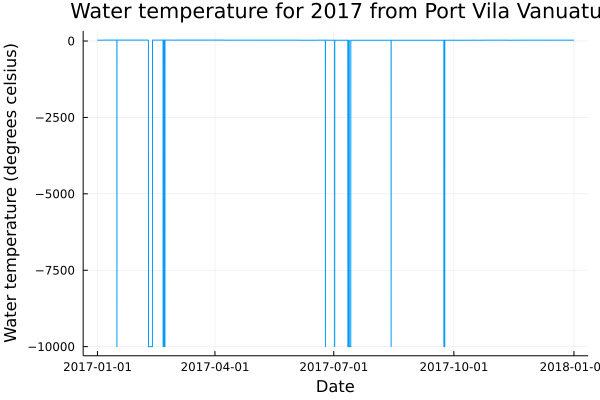

In [111]:
plot(w_temp[:, 1], w_temp[:, 2], 
    xlabel = "Date",
    ylabel = "Water temperature (degrees celsius)",
    label = false, 
    title = "Water temperature for 2017 from Port Vila Vanuatu")

In [112]:
describe(w_temp)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,datetime2,,2017-01-01T00:00:00,,2017-12-31T23:00:00,0,DateTime
2,water_temp,-139.772,-9999.0,27.0,31.0,0,Float64


Here we see what looks like a default or missing value of -9999.0 if there is no info.
Remove all data from the `w_temp` that has a value of -9999.0.

In [113]:
find = findall(w_temp[:, 2] .== -9999.0)
delete!(w_temp, find);

Now we check the plot and description of the data and see if this has taken care of things or if more needs to be done.

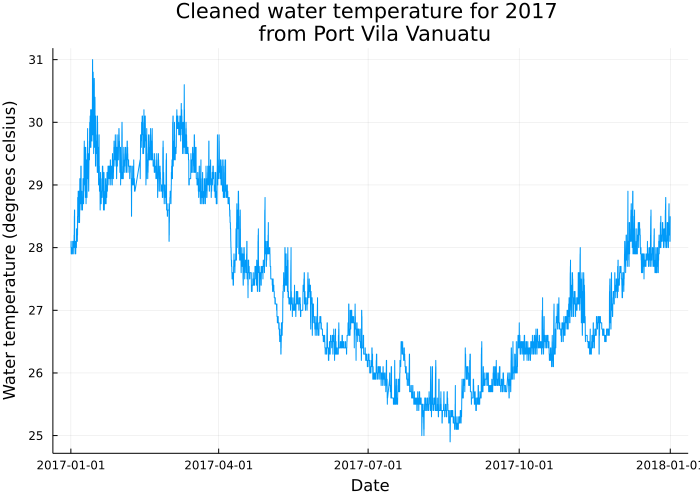

In [114]:
plot(w_temp[:, 1], w_temp[:, 2], 
    xlabel = "Date",
    ylabel = "Water temperature (degrees celsius)",
    label = false, 
    title = "Cleaned water temperature for 2017 \n from Port Vila Vanuatu",
    size = (700, 500))

In [115]:
describe(w_temp)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,datetime2,,2017-01-01T00:00:00,,2017-12-31T23:00:00,0,DateTime
2,water_temp,27.334,24.9,27.1,31.0,0,Float64


This looks to be much more reasonable.
The mean water temperature and median are close (27.334 and 27.1 respectively) and the water is warmest in the summer months, drops through autumn and is lowest in winter.

Now we fit some harmonics to the data to see if we can capture the annual trend the water temperature follows.
I would assume that a single harmonic will fit the data best but we fit and see.

## Air temperature
First plot the full air temperature data.

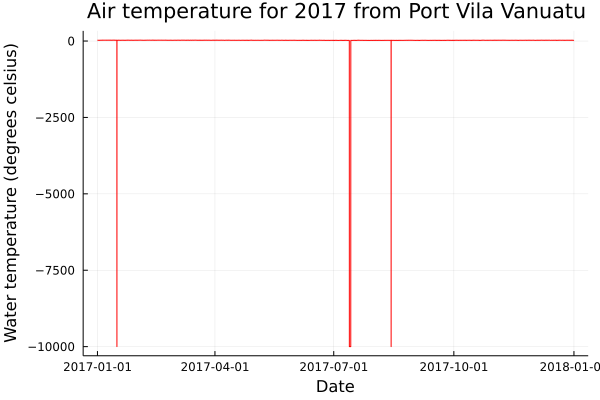

In [116]:
plot(a_temp[:, 1], a_temp[:, 2], 
    xlabel = "Date",
    ylabel = "Water temperature (degrees celsius)",
    label = false, 
    title = "Air temperature for 2017 from Port Vila Vanuatu",
    color = :red)

In [117]:
describe(a_temp)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,datetime2,,2017-01-01T00:00:00,,2017-12-31T23:00:00,0,DateTime
2,air_temp,-7.48828,-9999.0,25.6,32.7,0,Float64


Again remove the data entries corresponding to -9999.0 which are causing problems.

In [118]:
find = findall(a_temp[:, 2] .== -9999.0)
delete!(a_temp, find);

Now we check to see if this has cleaned things up.

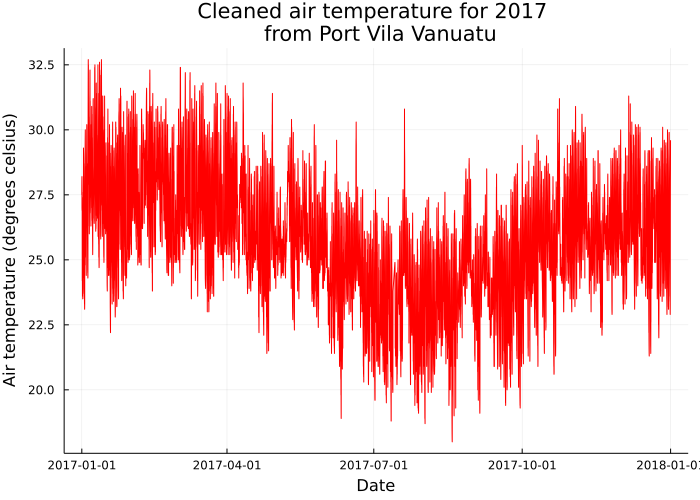

In [119]:
plot(a_temp[:, 1], a_temp[:, 2], 
    xlabel = "Date",
    ylabel = "Air temperature (degrees celsius)",
    label = false, 
    title = "Cleaned air temperature for 2017 \n from Port Vila Vanuatu",
    size = (700, 500), 
    color = :red)

In [120]:
describe(a_temp)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,datetime2,,2017-01-01T00:00:00,,2017-12-31T23:00:00,0,DateTime
2,air_temp,25.6985,18.0,25.6,32.7,0,Float64


Again this has cleared things up.
The mean and median are now much closer (almost the same) and the air temperature follows the annual cycle of warmer in summer and cooler in winter.

# Sea level
First look at the full sea level data

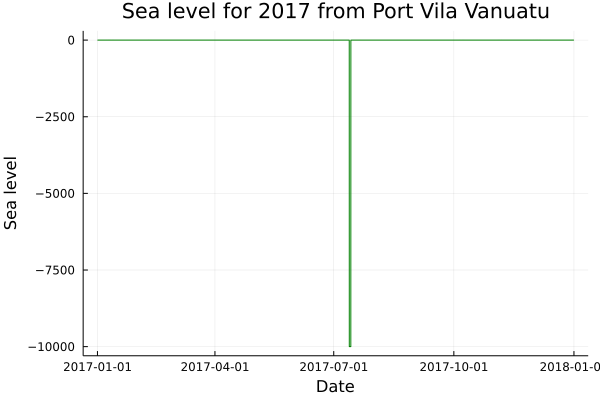

In [121]:
plot(sea_lvl[:, 1], sea_lvl[:, 2], 
    xlabel = "Date",
    ylabel = "Sea level",
    label = false, 
    title = "Sea level for 2017 from Port Vila Vanuatu",
    color = :green)

Again there is data corresponding to -9999.0 that needs to be removed.

In [122]:
find = findall(sea_lvl[:, 2] .== -9999.0)
delete!(sea_lvl, find);

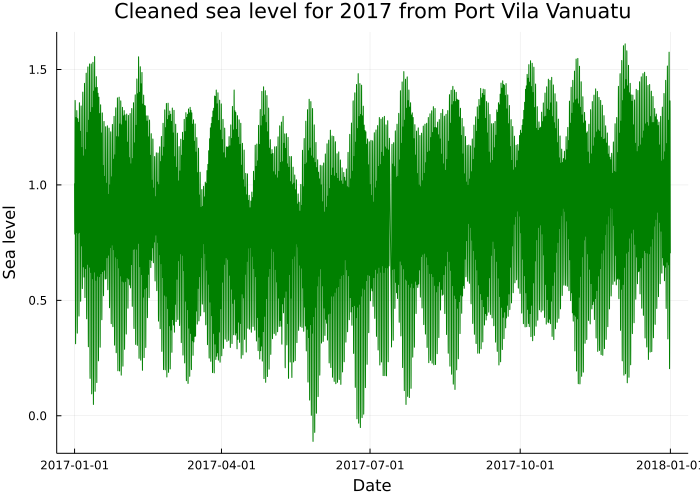

In [123]:
plot(sea_lvl[:, 1], sea_lvl[:, 2],
    xlabel = "Date",
    ylabel = "Sea level",
    label = false, 
    title = "Cleaned sea level for 2017 from Port Vila Vanuatu",
    size = (700, 500),
    color = :green)

In [124]:
describe(sea_lvl)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,datetime2,,2017-01-01T00:00:00,,2017-12-31T23:00:00,0,DateTime
2,sea_level,0.851854,-0.111,0.861,1.611,0,Float64


Again removing the observations that were entered as -9999.0 has cleared things up and what looks to be a monthly cycle has appeared.

We can look at the first 3 months of the data and if that shows anything.

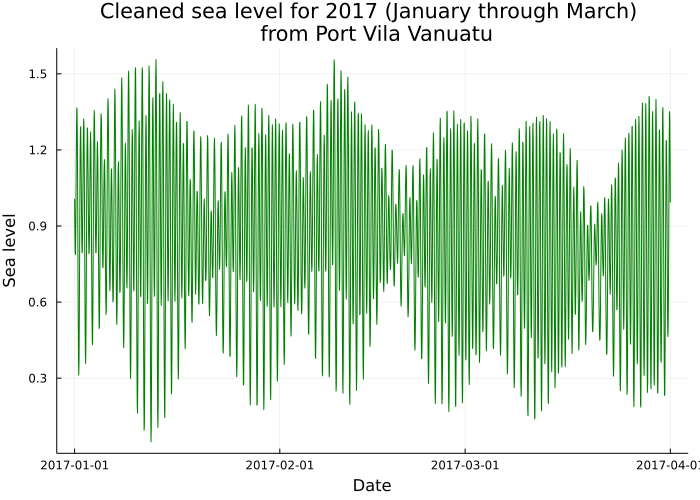

In [127]:
find_april = findfirst(sea_lvl[:, 1] .== DateTime(2017, 4, 1, 00, 00, 00))
plot(sea_lvl[1:find_april, 1], sea_lvl[1:find_april, 2],
    xlabel = "Date",
    ylabel = "Sea level",
    label = false, 
    title = "Cleaned sea level for 2017 (January through March) \n from Port Vila Vanuatu",
    size = (700, 500),
    color = :green)